The aim of this recommended practice is to generate a NDVI map for the assessment of the waters  affected by the WH using the ndvi

Import the required packages

In [10]:
import osr
import ogr
import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import glob
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import math
import rasterio as rio
from osgeo import gdal, gdal_array
import os

Function definitions



In [2]:
def read_band_image(band, path):
    """
    This function takes as input the Sentinel-2 band name and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   band           string            Sentinel-2 band name
             path           string            path of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    a = path+'*B'+band+'*.jp2'
    img = gdal.Open(glob.glob(a)[0])
    data = np.array(img.GetRasterBand(1).ReadAsArray())
    spatialRef = img.GetProjection()
    geoTransform = img.GetGeoTransform()
    targetprj = osr.SpatialReference(wkt = img.GetProjection())
    return data, spatialRef, geoTransform, targetprj

def nbr(band1, band2):
    """
    This function takes an input the arrays of the bands from the read_band_image
    function and returns the Normalized Burn ratio (NBR)
    input:  band1   array (n x m)      array of first band image e.g B8A
            band2   array (n x m)      array of second band image e.g. B12
    output: nbr     array (n x m)      normalized burn ratio
    """
    nbr = (band1 - band2) / (band1 + band2)
    return nbr

def dnbr(nbr1,nbr2):
    """
    This function takes as input the pre- and post-fire NBR and returns the dNBR
    input:  nbr1     array (n x m)       pre-fire NBR
            nbr2     array (n x m)       post-fire NBR
    output: dnbr     array (n x m)       dNBR
    """
    dnbr = nbr1 - nbr2
    return dnbr

def reproject_shp_gdal(infile, outfile, targetprj):
    """
    This function takes as input the input and output file names and the projection
    in which the input file will be reprojected and reprojects the input file using
    gdal
    input:  infile     string      input filename
            outfile    string      output filename
            targetprj              projection (output of function read_band_image)
    """
    ## reprojection with gdal 
    
    driver = ogr.GetDriverByName("ESRI Shapefile") 
    dataSource = driver.Open(infile, 1) # 0 means read-only. 1 means writeable.
    layer = dataSource.GetLayer()
    sourceprj = layer.GetSpatialRef()
    transform = osr.CoordinateTransformation(sourceprj, targetprj)
    
    # Create the output shapefile
    outDriver = ogr.GetDriverByName("Esri Shapefile")
    outDataSource = outDriver.CreateDataSource(outfile)
    outlayer = outDataSource.CreateLayer('', targetprj, ogr.wkbPolygon)
    outlayer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
    
    #Iterate over Features
    i = 0
    for feature in layer:
        transformed = feature.GetGeometryRef()
        transformed.Transform(transform) #reproject geometry

        geom = ogr.CreateGeometryFromWkb(transformed.ExportToWkb()) # create geometry from wkb (write geometry of reprojected geometry)
        defn = outlayer.GetLayerDefn() #layer definition
        feat = ogr.Feature(defn)  #create new feature
        feat.SetField('id', i) #set id
        feat.SetGeometry(geom) #set geometry
        outlayer.CreateFeature(feat) 
        i += 1
        feat = None
        
def array2raster(array, geoTransform, projection, filename):
    """ 
    This function tarnsforms a numpy array to a geotiff projected raster
    input:  array                       array (n x m)   input array
            geoTransform                tuple           affine transformation coefficients
            projection                  string          projection
            filename                    string          output filename
    output: dataset                                     gdal raster dataset
            dataset.GetRasterBand(1)                    band object of dataset
    
    """
    pixels_x = array.shape[1]
    pixels_y = array.shape[0]
    
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(
        filename,
        pixels_x,
        pixels_y,
        1,
        gdal.GDT_Float64, )
    dataset.SetGeoTransform(geoTransform)
    dataset.SetProjection(projection)
    dataset.GetRasterBand(1).WriteArray(array)
    dataset.FlushCache()  # Write to disk.
    return dataset, dataset.GetRasterBand(1)  #If you need to return, remenber to return  also the dataset because the band don`t live without dataset.
 
def clip_raster(filename, shp):
    """
    This function clips a raster based on a shapefile
    input:  filename          string                input raster filename
            shp               dataframe             input shapefile open with geopandas
    output: clipped           array (1 x n x m)     clipped array 
            clipped_meta      dict                  metadata
            cr_ext            tuple                 extent of clipped data
            gt                tuple                 affine transformation coefficients
    """
    inraster = rasterio.open(filename)
    
    extent_geojson = mapping(shp['geometry'][0])
    clipped, crop_affine = mask(inraster, 
                                shapes=[extent_geojson], 
                                nodata = np.nan,
                                crop=True)
    clipped_meta = inraster.meta.copy()
    # Update the metadata to have the new shape (x and y and affine information)
    clipped_meta.update({"driver": "GTiff",
                 "height": clipped.shape[0],
                 "width": clipped.shape[1],
                 "transform": crop_affine})
    cr_ext = rasterio.transform.array_bounds(clipped_meta['height'], 
                                            clipped_meta['width'], 
                                            clipped_meta['transform'])
    
    # transform to gdal
    gt = crop_affine.to_gdal()
    
    return clipped, clipped_meta, cr_ext, gt
    
def reclassify(array):
    """
    This function reclassifies an array
    input:  array           array (n x m)    input array
    output: reclass         array (n x m)    reclassified array
    """
    reclass = np.zeros((array.shape[0],array.shape[1]))
    for i in range(0,array.shape[0]):
        for j in range(0,array.shape[1]):
            if math.isnan(array[i,j]):
                reclass[i,j] = np.nan
            elif array[i,j] < 0.1:
                reclass[i,j] = 1
            elif array[i,j] < 0.27:
                 reclass[i,j] = 2
            elif array[i,j] < 0.44:
                 reclass[i,j] = 3
            elif array[i,j] < 0.66:
                 reclass[i,j] = 4
            else:
                reclass[i,j] = 5
                
    return reclass

In [6]:
def read_band_image(path,dronedata):
    """
    This function takes as input the ldrone image and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   drone          drone image
             path           string            path ,of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    import os
    #img_ds = rio.open(r'T:\Aktive\DSU\3434\52232_Barkbilleskader_S_2\aux_data' + r'\dtm16m_utm32.tif')
    #img_ds1 = rio.open(path + dronedata)
    
    os.chdir(path)
    os.getcwd()
    #img_ds = gdal.Open(glob.glob(a)[0])
    img_ds = gdal.Open(dronedata, gdal.GA_ReadOnly)


    # gdal_rasterize -a HKL_VERDI -ot Float32 -of GTiff  -tr 20 20 -te 591964.4892070280620828 6607127.0049451533704996 609364.4892070280620828 6627967.0049451533704996  -l SKOGBRUKSPLAN_BESTAND_FLATE_0214_d5685 SKOGBRUKSPLAN_BESTAND_FLATE_0214_d5685.shp SKOGBRUKSPLAN_BESTAND_FLATE_0214_d5685_hklverdi.tif
    data = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
                   gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

    for b in range(data.shape[2]):
        data[:, :, b] = np.array(img_ds.GetRasterBand(b + 1).ReadAsArray())


    
    spatialRef = img_ds.GetProjection()
    geoTransform = img_ds.GetGeoTransform()
    targetprj = osr.SpatialReference(wkt = img_ds.GetProjection())
    return data, spatialRef, geoTransform, targetprj

def ndvi(data):
    """
    This function takes an input the arrays of the bands from the read_band_image
    function and returns the NDVI
    input:  band1   array (n x m)      array of first band image e.g B1
            band2   array (n x m)      array of second band image e.g. B4
    output: ndvi     array (n x m)      normalized vegetation index
    """
    band1=data[:,:,4]
    band2=data[:,:,2]

    ndvi = (band1 - band2) / (band1 + band2)
    return ndvi

def CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None,GeoT=None, Projection=None):
# If it's a 2D image we fake a third dimension:
    if len(Array.shape)==2:
        Array=np.array([Array])
    if ref_image==None and (GeoT==None or Projection==None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                .format(Array.shape[0],len(bandnames)))
    else:
        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image!= None:
        refimg=gdal.Open(ref_image)
        GeoT=refimg.GetGeoTransform()
        Projection=refimg.GetProjection()
    driver= gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(Name,Array.shape[2],Array.shape[1],Array.shape[0],DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
        DataSet.SetDescription(bandnames[i-1])
    DataSet.FlushCache()
    return Name

In [8]:
def read_band_image(path,dronedata):
    """
    This function takes as input the ldrone image and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   drone          drone image
             path           string            path ,of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    
    os.chdir(path)
    os.getcwd()
    img_ds = gdal.Open(dronedata, gdal.GA_ReadOnly)
    data = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
                   gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

    for b in range(data.shape[2]):
        data[:, :, b] = np.array(img_ds.GetRasterBand(b + 1).ReadAsArray())


    spatialRef = img_ds.GetProjection()
    geoTransform = img_ds.GetGeoTransform()
    targetprj = osr.SpatialReference(wkt = img_ds.GetProjection())
    return data, spatialRef, geoTransform, targetprj


In the following cell you should have to modify the paths for the images and the shapefile


In [12]:
# Paths
path = r'C:\Users\vaak\Desktop\UoS\weedwatch project\Transfer Learning'
#inputfile='Orthomosaic_30Apr2021_PatanCheru.tif'
inputfile1='Orthomosaic_28Jan2021_PatanCheru.tif'
inputfile2='Orthomosaic_26Mar2021_PatanCheru.tif'
# Define shapefile
#infile_shp = 'Test3_Test4_AOI.shp'
# Define reprojected shapefile
#outfile_shp = 'Test3_Test4_AOI_reprojected.shp'
# name of clipped drone rastr
#filename = path+"\Orthomosaic_30Apr2021_PatanCheru_NDVI.tif"
#filename = path+"\Orthomosaic_28Jan2021_PatanCheru_NDVI.tif"


# name of NDVI raster
#filename2 = path+"\Orthomosaic_30Apr2021_PatanCheru_clipped_NDVI.tif"
#filename2 = path+"\Orthomosaic_28Jan2021_PatanCheru_NDVI.tif"

# path to save figure
#fname =path+"ndvi_map.png"

# Drne Bands used for NDVI calculation 
band1 = 'B3'
band2 = 'B5'

# Read drone bands 
path = r'C:\Users\vaak\Desktop\UoS\weedwatch project\Transfer Learning'
inputfile1='Orthomosaic_28Jan2021_PatanCheru_AOI.vrt'
inputfile2='Orthomosaic_26Mar2021_PatanCheru_AOI.vrt'
(dronedata1, crs1, geoTransform1, targetprj1) = read_band_image(path,inputfile1)
(dronedata2, crs2, geoTransform2, targetprj2) = read_band_image(path,inputfile2)

(NDVI1) = read_band_image(path,filename)


# Calculation of NDVI
NDVI1 = ndvi(dronedata1)
NDVI2 = ndvi(dronedata2)

# Reprojection of shapefile with gdal to match projection of Sentinel-2 images
#reproject_shp_gdal(infile_shp, outfile_shp, targetprj)
   
# Read the reprojected shapefile
#aoi_boundary = gpd.read_file(outfile_shp)

# project NDVI to images projection
#ndvi_tif, ndvi_tifBand = array2raster(NDVI, geoTransform, crs, filename)
#bandnames=['ndvi']
#CreateGeoTiff(filename, NDVI,gdal.GDT_Float32,0,bandnames,GeoT=geoTransform,Projection=crs)
# clip raster NDVI file to the shapefile
#(clipped_ndvi, clipped_ndvi_meta, cr_extent, gt) = clip_raster(filename, aoi_boundary)


AttributeError: 'NoneType' object has no attribute 'RasterYSize'

In [52]:
def reclassify(array):
    """
    This function reclassifies an array
    input:  array           array (n x m)    input array
    output: reclass         array (n x m)    reclassified array
    """
    reclass = np.zeros((array.shape[0],array.shape[1]))
    for i in range(0,array.shape[0]):
        for j in range(0,array.shape[1]):
            if math.isnan(array[i,j]):
                reclass[i,j] = np.nan
            elif array[i,j] < 0.1:
                reclass[i,j] = 1
            elif array[i,j] < 0.27:
                 reclass[i,j] = 2
            elif array[i,j] < 0.44:
                 reclass[i,j] = 3
            elif array[i,j] < 0.66:
                 reclass[i,j] = 4
            else:
                reclass[i,j] = 5
                
    return reclass

In [ ]:
Mask2=np.array(dronedata2>0)
Mask2=Mask2[:,:,0]
Mask2=Mask2.astype('uint8')

f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(111)
pos=ax1.imshow(Mask2)
ax1.set_title('Mask for March data',fontsize=20)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);

In [ ]:
NDVI1 = ndvi(dronedata1)
dronedata2[dronedata2<0]=65535
NDVI2 = ndvi(dronedata2)
#(NDVI1, crs1, geoTransform1, targetprj1)  = read_band_image(path,filename)

#reclass1 = reclassify(NDVI1)

In [88]:
def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

In [97]:
NDVI1=norm(NDVI1)
NDVI2=norm(NDVI2)


In [ ]:
#scale=[0,1]
#NDVI1 = np.abs(NDVI1)/(np.abs(scale).mean())
#NDVI1[np.abs(NDVI1) > 1] = 1
#NDVI1[np.abs(NDVI1) < 0] = 0

#NDVI2 = np.abs(NDVI2)/(np.abs(scale).mean())
#NDVI2[np.abs(NDVI2) > 1] = 1
#NDVI2[np.abs(NDVI2) < 0] = 0
        
NDVI2=NDVI2*Mask2
fig = plt.figure(figsize=(20,10))

#ax1 = fig.add_subplot(2,2,2); plt.title('ndvi1')
#amap1_hist = plt.hist(np.ndarray.flatten(NDVI1),bins=50,range=[0.05,1.2]) 

#ax2 = fig.add_subplot(2,2,4); plt.title('ndvi2')
#amap1_hist = plt.hist(np.ndarray.flatten(NDVI2),bins=50,range=[0.05,0.5]) 

ax3 = fig.add_subplot(1,2,1); plt.title('ndvi1')
plot=plt.imshow(NDVI1)
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('Greens'); 
cbar.set_label('NDVI',rotation=90,labelpad=20); 
ax3.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax3.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
    
ax4 = fig.add_subplot(1,2,2); plt.title('ndvi2')
plot=plt.imshow(NDVI2[:23000,:16500])
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('Greens'); 
cbar.set_label('NDVI',rotation=90,labelpad=20); 
ax4.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax4.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
    
    

In [42]:
def visRGB(img1, img2, img3,
           title = 'RGB image',
           scale1 = [],
           scale2 = [],
           scale3 = [],
           flag = 0, outall = ''):
    """
    Visualise the RGB of a single acquisition
    """           
    if scale1 == []:
       scale1 = img1
    if scale2 == []:
       scale2 = img2
    if scale3 == []:
       scale3 = img3

    size = np.shape(img1)           
    iRGB = np.zeros([size[0],size[1],3])
    iRGB[:,:,0] = np.abs(img1)/(np.abs(scale1).mean()*1.5)
    iRGB[:,:,1] = np.abs(img2)/(np.abs(scale2).mean()*1.5)
    iRGB[:,:,2] = np.abs(img3)/(np.abs(scale3).mean()*1.5)
    iRGB[np.abs(iRGB) > 1] = 1
            
#    plt.figure()

    fig = plt.figure(figsize=(10,10))
    ax2 = fig.add_subplot(1,1,1)
    plot = plt.imshow(iRGB); 
    plt.title('(RGB image'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

    if flag == 1:
        fig.savefig(outall)

    return       
           

In [143]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore') #don't display warnings

In [ ]:
import sys
# You will need to download the package using the link above 
# and re-point the filepath to the tar.gz file below
!{sys.executable} -m pip install "C:\Users\vaak\Desktop\pysptools-0.15.0.tar.gz"
!conda install --yes --prefix {sys.prefix} scikit-learn
!conda install --yes --prefix {sys.prefix} cvxopt

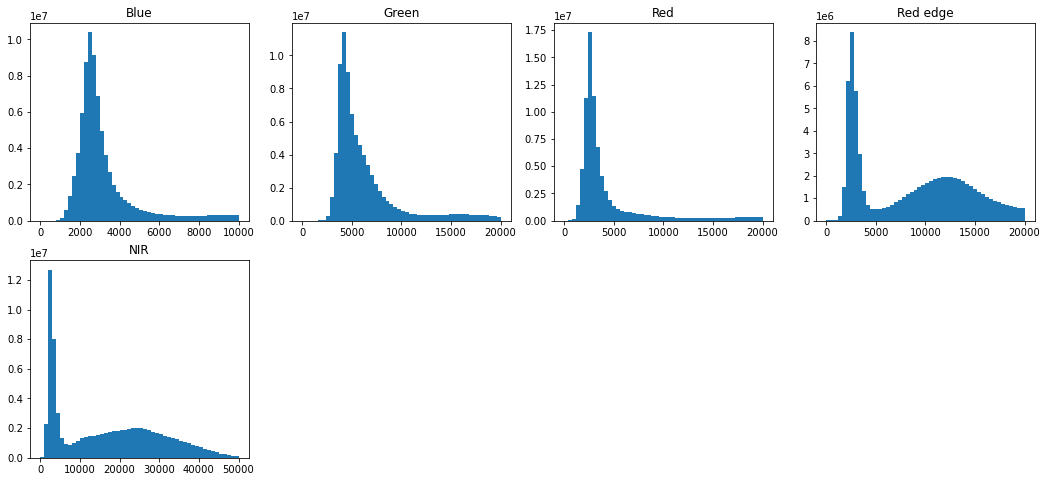

In [162]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(2,4,1); plt.title('Blue')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata1[:,:,0]),bins=50,range=[0,10000]) 

ax2 = fig.add_subplot(2,4,2); plt.title('Green')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata1[:,:,1]),bins=50,range=[0,20000]) 

ax3 = fig.add_subplot(2,4,3); plt.title('Red')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata1[:,:,2]),bins=50,range=[0,20000]) 

ax4 = fig.add_subplot(2,4,4); plt.title('Red edge')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata1[:,:,3]),bins=50,range=[0,20000]) 

ax5 = fig.add_subplot(2,4,5); plt.title('NIR')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata1[:,:,4]),bins=50,range=[0,50000]) 


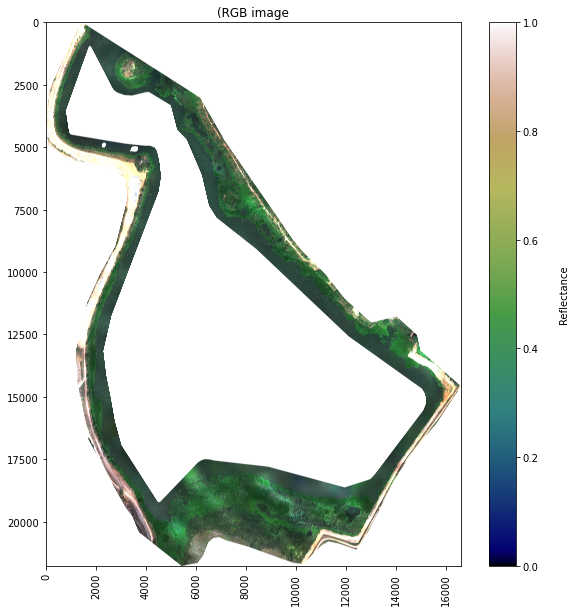

In [43]:
visRGB(dronedata1[:,:,2], dronedata1[:,:,1], dronedata1[:,:,0],
           title = 'RGB image',
           scale1 = [0,20000],
           scale2 = [0,20000],
           scale3 = [0,15000],
           flag = 0, outall = '')


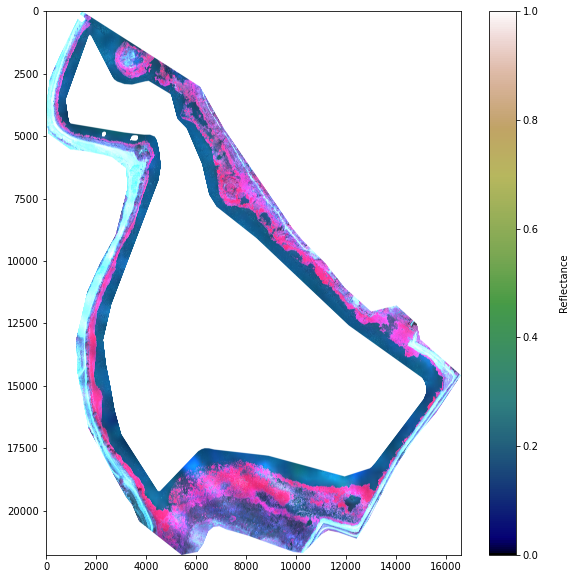

In [363]:
clipExtent = {}
clipExtent['xMin'] = 78.2592307422399216
clipExtent['xMax'] = 78.2672988704719188
clipExtent['yMin'] = 17.5182733390502108
clipExtent['yMax'] = 17.5284223207622105

clipExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])
visRGB(dronedata1[:,:,4], dronedata1[:,:,0], dronedata1[:,:,1],
           title = 'RGB image',
           scale1 = [0,50000],
           scale2 = [0,10000],
           scale3 = [0,10000],
           flag = 0, outall = '')





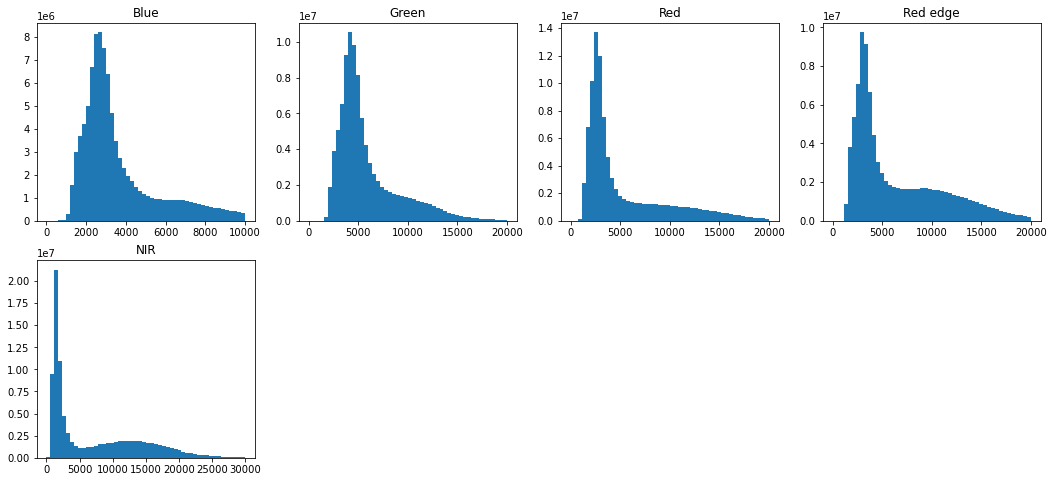

In [94]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(2,4,1); plt.title('Blue')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata2[:,:,0]),bins=50,range=[0,10000]) 

ax2 = fig.add_subplot(2,4,2); plt.title('Green')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata2[:,:,1]),bins=50,range=[0,20000]) 

ax3 = fig.add_subplot(2,4,3); plt.title('Red')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata2[:,:,2]),bins=50,range=[0,20000]) 

ax4 = fig.add_subplot(2,4,4); plt.title('Red edge')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata2[:,:,3]),bins=50,range=[0,20000]) 

ax5 = fig.add_subplot(2,4,5); plt.title('NIR')
amap1_hist = plt.hist(np.ndarray.flatten(dronedata2[:,:,4]),bins=50,range=[0,30000]) 


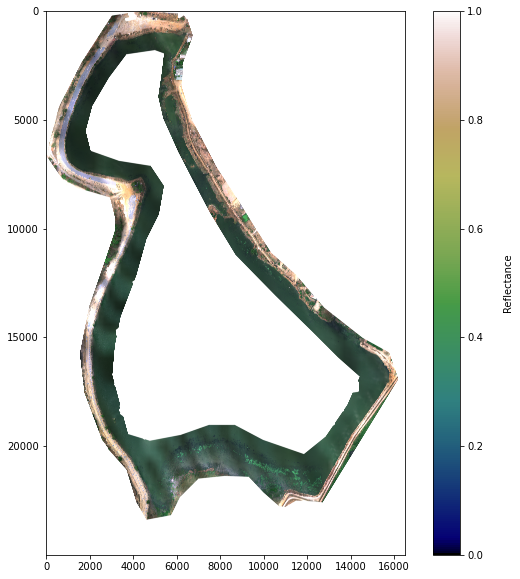

In [368]:
visRGB(dronedata2[:,:16500,2], dronedata2[:,:16500,1], dronedata2[:,:16500,0],
           title = 'RGB image',
           scale1 = [0,20000],
           scale2 = [0,20000],
           scale3 = [0,15000],
           flag = 0, outall = '')


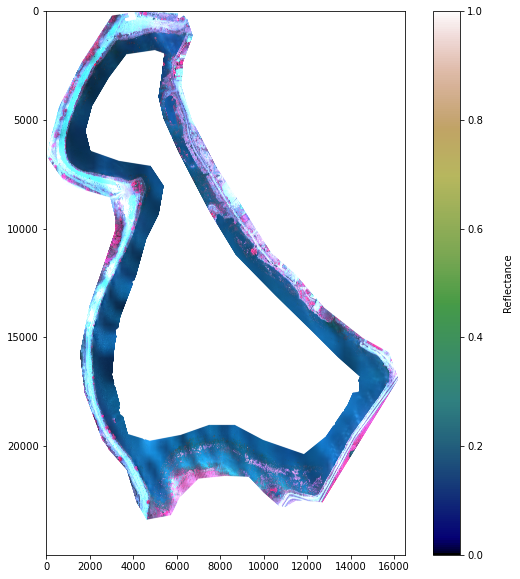

In [184]:


visRGB(dronedata2[:,:16500,4], dronedata2[:,:16500,0], dronedata2[:,:16500,1],
           title = 'NIR, BLUE, GREEN',
           scale1 = [0,30000],
           scale2 = [0,10000],
           scale3 = [0,10000],
           flag = 0, outall = '')

In [113]:
import  os, copy
import matplotlib.pyplot as plt
import numpy as np
import pysptools.util as util
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
import pysptools.material_count as cnt

%matplotlib inline

#for clean output, to not print warnings, don't use when developing script
import warnings
warnings.filterwarnings('ignore')

In [78]:
print('Abundance Map Mean Values:')
print('band1:',np.mean(dronedata[:,:,0]))
print('band2:',np.mean(dronedata[:,:,1]))
print('band3:',np.mean(dronedata[:,:,2]))
print('band4:',np.mean(dronedata[:,:,3]))
print('band4:',np.mean(dronedata[:,:,4]))
print('NDVI:',np.mean(NDVI))

Abundance Map Mean Values:
band1: 51540.11203681193
band2: 52186.50898798626
band3: 51905.691339536104
band4: 53046.06501852512
band4: 54583.14157644218
NDVI: nan


In [100]:
geoTransform

(78.25923074223992,
 4.859439999998318e-07,
 0.0,
 17.52842232076221,
 0.0,
 -4.66233999999988e-07)

In [25]:
import pandas as pd
from rasterstats import zonal_stats
import os

inputfile1='Orthomosaic_28Jan2021_PatanCheru.tif'

df1 = pd.DataFrame(columns=[ 'Site Number','Lat','Lon','Blue', 'Green','Red', 'RE', 'NIR'])
shpfile='testsites.shp'

Blue = zonal_stats(shpfile, inputfile1, band=1,stats="mean",nodata=-999)
Green = zonal_stats(shpfile, inputfile1, band=2,stats="mean",nodata=-999)
Red = zonal_stats(shpfile, inputfile1, band=3,stats="mean",nodata=-999)
RE = zonal_stats(shpfile, inputfile1, band=4,stats="mean",nodata=-999)
NIR = zonal_stats(shpfile, inputfile1, band=5,stats="mean",nodata=-999)
#NDVI=zonal_stats(shpfile, NDVIfile, band=1,stats="mean",nodata=-999)

Sites = gpd.read_file(shpfile)
df1['Site Number']=Sites['S.No']
df1['Lat']=Sites['Latitude']
df1['Lon']=Sites['Longitude']
df1['Blue'] = [img['mean'] for img in Blue]
df1['Green'] = [img['mean'] for img in Green] 
df1['Red'] = [img['mean'] for img in Red]
df1['RE'] = [img['mean'] for img in RE] 
df1['NIR'] = [img['mean'] for img in NIR] 


#NDVI_2019_8 = zonal_stats(os.path.join(AGBdirectory,shpfile), os.path.join(S2directory, NDVI_2019_8), band=1,stats="mean",nodata=-999)
#NDVI_2019_51 = zonal_stats(os.path.join(AGBdirectory,shpfile), os.path.join(S2directory, NDVI_2019_51), band=1,stats="mean",nodata=-999)
#NDVI_2019_51a = zonal_stats(os.path.join(AGBdirectory,shpfile), os.path.join(S2directory, NDVI_2019_51a), band=1,stats="mean",nodata=-999)

In [27]:
import pandas as pd
from rasterstats import zonal_stats
import os

inputfile2='Orthomosaic_26Mar2021_PatanCheru.tif'

df2 = pd.DataFrame(columns=[ 'Site Number','Lat','Lon','Blue', 'Green','Red', 'RE', 'NIR'])
shpfile='testsites.shp'

Blue = zonal_stats(shpfile, inputfile2, band=1,stats="mean",nodata=-999)
Green = zonal_stats(shpfile, inputfile2, band=2,stats="mean",nodata=-999)
Red = zonal_stats(shpfile, inputfile2, band=3,stats="mean",nodata=-999)
RE = zonal_stats(shpfile, inputfile2, band=4,stats="mean",nodata=-999)
NIR = zonal_stats(shpfile, inputfile2, band=5,stats="mean",nodata=-999)
#NDVI=zonal_stats(shpfile, NDVIfile, band=1,stats="mean",nodata=-999)

Sites = gpd.read_file(shpfile)
df2['Site Number']=Sites['S.No']
df2['Lat']=Sites['Latitude']
df2['Lon']=Sites['Longitude']
df2['Blue'] = [img['mean'] for img in Blue]
df2['Green'] = [img['mean'] for img in Green] 
df2['Red'] = [img['mean'] for img in Red]
df2['RE'] = [img['mean'] for img in RE] 
df2['NIR'] = [img['mean'] for img in NIR] 


#NDVI_2019_8 = zonal_stats(os.path.join(AGBdirectory,shpfile), os.path.join(S2directory, NDVI_2019_8), band=1,stats="mean",nodata=-999)
#NDVI_2019_51 = zonal_stats(os.path.join(AGBdirectory,shpfile), os.path.join(S2directory, NDVI_2019_51), band=1,stats="mean",nodata=-999)
#NDVI_2019_51a = zonal_stats(os.path.join(AGBdirectory,shpfile), os.path.join(S2directory, NDVI_2019_51a), band=1,stats="mean",nodata=-999)

In [29]:
df2

,Site Number,Lat,Lon,Blue,Green,Red,RE,NIR
0,1,17.528967,78.260539,3891.264893,4884.618164,6104.094727,6650.996582,8768.283203
1,2,17.521503,78.260028,6539.078613,8765.289062,9424.775391,9954.780273,9943.708008
2,3,17.519392,78.261072,3118.547607,4530.789062,4616.559082,6956.667969,9508.122070
3,4,17.518817,78.264503,6860.163574,10609.239258,13629.466797,14704.369141,17455.181641
4,5,17.522047,78.266511,6488.714355,10322.823242,12306.279297,12977.920898,13376.561523
5,6,17.529006,78.260561,2600.011719,3850.908447,4669.913574,5043.531250,6999.708008
6,7,17.521648,78.259979,9891.047852,9779.255859,9775.931641,9116.489258,9497.010742
7,8,17.519507,78.260969,8894.316406,12604.217773,15088.205078,14757.333008,16292.893555
8,9,17.518794,78.264486,5425.666992,8018.872559,8558.889648,10162.333008,13356.385742
9,10,17.522044,78.266511,7916.170898,10471.025391,13390.217773,13730.069336,13391.920898


In [43]:
latmax=geoTransform1[3]
lonmin=geoTransform1[0]
Gres_lat=geoTransform1[5]
Gres_lon=geoTransform1[1]

#Site 2
lat=df1['Lat'][1]
lon=df1['Lon'][1]



#Site 3
#lat=17.51939167
#lon=78.26111111

#Site 4
#lat=17.51881667
#lon=78.26444444

x0 = int((lon - lonmin) / abs(Gres_lon))
y0= int((latmax - lat) /abs(Gres_lat))
print(x0)
print(y0)



latmax=geoTransform2[3]
lonmin=geoTransform2[0]
Gres_lat=geoTransform2[5]
Gres_lon=geoTransform2[1]

x1 = int((lon - lonmin) / abs(Gres_lon))
y1 = int((latmax - lat) /abs(Gres_lat))
print(x1)
print(y1)


1640
14840


In [339]:
dronedata1=norm(dronedata1)

Text(0.5, 1.0, 'Spectral Signature for 5 Sites ')

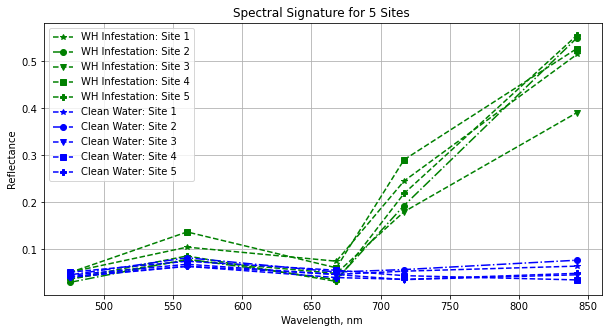

In [359]:
#WH for site 1, 2
x0_2=2191
y0_2=15504
x0_1=1503
y0_1=619
x0_3=3791
y0_3=19372
x0_4=10751
y0_4=20438
x0_5=14651
y0_5=13697


#CLEAN WATER
x1_1=1764
y1_1=861
x1_2=2254
y1_2=11950
x1_3=4134
y1_3=19072
x1_4=10573
y1_4=18598
x1_5=14751
y1_5=14037



# Clean Water arround site 2


import pandas as pd
specsig_pixel_df = pd.DataFrame()
specsig_pixel_df['wavelengths'] = [475,560,668,717,842]



specsig_pixel_df['reflectance_WH_Site1'] = dronedata1[y0_1,x0_1,:5]
specsig_pixel_df['reflectance_WH_Site2'] = dronedata1[y0_2,x0_2,:5]
specsig_pixel_df['reflectance_WH_Site3'] = dronedata1[y0_3,x0_3,:5]
specsig_pixel_df['reflectance_WH_Site4'] = dronedata1[y0_4,x0_4,:5]
specsig_pixel_df['reflectance_WH_Site5'] = dronedata1[y0_5,x0_5,:5]


specsig_pixel_df['reflectance_CW_Site1'] = dronedata1[y1_1,x1_1,:5]
specsig_pixel_df['reflectance_CW_Site2'] = dronedata1[y1_2,x1_2,:5]
specsig_pixel_df['reflectance_CW_Site3'] = dronedata1[y1_3,x1_3,:5]
specsig_pixel_df['reflectance_CW_Site4'] = dronedata1[y1_4,x1_4,:5]
specsig_pixel_df['reflectance_CW_Site5'] = dronedata1[y1_5,x1_5,:5]


#specsig_pixel_df['reflectance_WH']=norm(specsig_pixel_df['reflectance_WH'])
#specsig_pixel_df['reflectance_CW']=norm(specsig_pixel_df['reflectance_CW'])

fig = plt.figure(figsize=(10,5))



# Clean Water arround site 2



plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_WH_Site1'],'g*--')
plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_WH_Site2'],'go-.')
plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_WH_Site3'],'gv--')
plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_WH_Site4'],'gs--')
plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_WH_Site5'],'gP--')


plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_CW_Site1'],'b*--')
plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_CW_Site2'],'bo-.')
plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_CW_Site3'],'bv--')
plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_CW_Site4'],'bs--')
plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_CW_Site5'],'bP--')


plt.xlabel('Wavelength, nm ')
plt.ylabel('Reflectance')
plt.grid('on')
plt.legend(['WH Infestation: Site 1','WH Infestation: Site 2', 'WH Infestation: Site 3','WH Infestation: Site 4', 'WH Infestation: Site 5',
           'Clean Water: Site 1','Clean Water: Site 2','Clean Water: Site 3','Clean Water: Site 4','Clean Water: Site 5'])
plt.title('Spectral Signature for 5 Sites ')
#plt.xlim(400,900)    
#plt.ylim(0, 20000)





In [49]:
# Clean Water arround site 2


import pandas as pd
specsig_pixel_df = pd.DataFrame()
specsig_pixel_df['wavelengths'] = [475,560,668,717,842]



specsig_pixel_df['reflectance_Ja'] = dronedata1[y0,x0,:5]


specsig_pixel_df['reflectance_Mar'] = np.ceil(dronedata2[y1,x1,:])
specsig_pixel_df


plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_'],'r*')
plt.plot(specsig_pixel_df['wavelengths'],specsig_pixel_df['reflectance_Mar'],'b*')

plt.xlabel('Wavelength, nm ')
plt.ylabel(' Spectral Signature')
plt.grid('on')
plt.legend(['Infested Water','Clean Water'])
plt.title('Spectral Signature for Site 2')
#plt.xlim(400,900)    
#plt.ylim(0, 20000)



,wavelengths,reflectance_Jan,reflectance_Mar
0,475,3689,6540.0
1,560,4984,8766.0
2,668,6144,9425.0
3,717,7006,9955.0
4,842,8882,9944.0


In [42]:
ee_axes = {} # set ee_axes data type to dictionary
# cast wavelength values to float to apply to ee_axes for display purposes
ee_axes['wavelength'] = [float(i) for i in specsig_pixel_df['wavelengths']]
ee_axes['x']='Wavelength, nm' #x axis label
ee_axes['y']='Reflectance' #y axis label 

In [237]:
from IPython.html.widgets import *

def spectraPlot(pixel_x,pixel_y):

    reflectance = dronedata[pixel_y,pixel_x,:]
    reflectance[nan_ind]=np.nan

    pixel_df = pd.DataFrame()
    pixel_df['reflectance'] = reflectance
    pixel_df['wavelengths'] = w

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,2,1)

    # fig, axes = plt.subplots(nrows=1, ncols=2)
    pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
    ax1.set_title('Spectra of Pixel (' + str(pixel_x) + ',' + str(pixel_y) + ')')
    ax1.set_xlim([np.min(metadata['wavelength']),np.max(metadata['wavelength'])]); 
    ax1.set_ylim([np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
    ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")
    ax1.grid('on')

    ax2 = fig.add_subplot(1,2,2)
    plot = plt.imshow(refl_band,extent=metadata['spatial extent'],clim=(0,0.1)); 
    plt.title('Pixel Location'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

    ax2.plot(metadata['spatial extent'][0]+pixel_x,metadata['spatial extent'][3]-pixel_y,'s',markersize=5,color='red')
    ax2.set_xlim(metadata['spatial extent'][0],metadata['spatial extent'][1])
    ax2.set_ylim(metadata['spatial extent'][2],metadata['spatial extent'][3])



1640 14847


(17.51827333905021, 17.52842232076221)

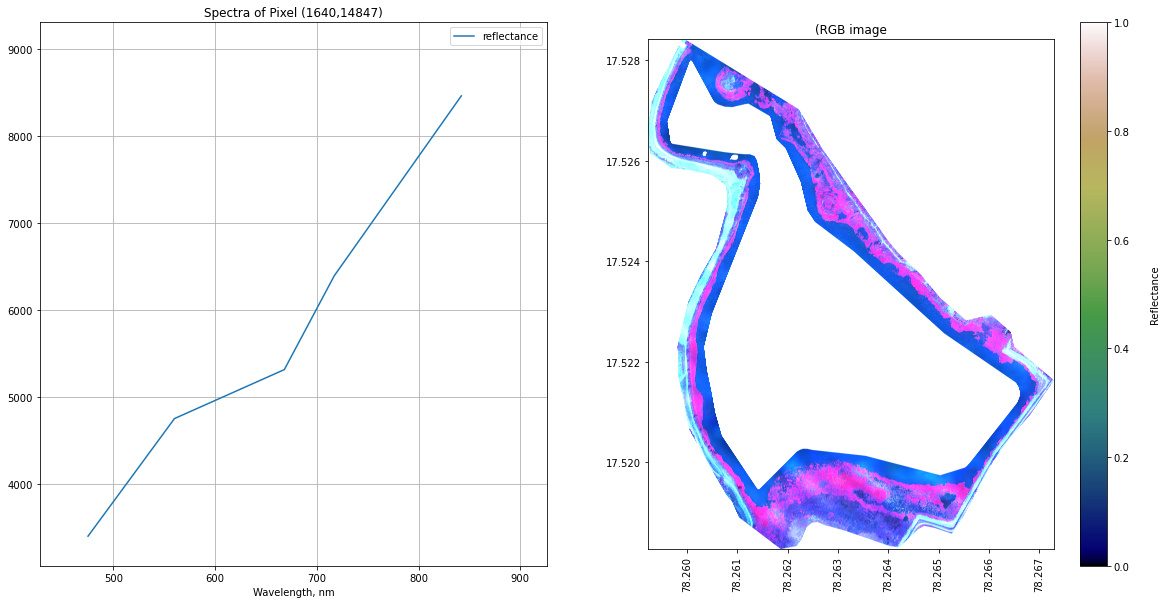

In [150]:
latmax=geoTransform1[3]
lonmin=geoTransform1[0]
Gres_lat=geoTransform1[5]
Gres_lon=geoTransform1[1]


#Site 2
lat=17.52150
lon=78.260028


#Site 3
#lat=17.51939167
#lon=78.26111111

#Site 4
#lat=17.51881667
#lon=78.26444444

pixel_x= int((lon - lonmin) / abs(Gres_lon))
pixel_y = int((latmax - lat) /abs(Gres_lat))
print(pixel_x,pixel_y)


clipExtent = {}
clipExtent['xMin'] = 78.2592307422399216
clipExtent['xMax'] = 78.2672988704719188
clipExtent['yMin'] = 17.5182733390502108
clipExtent['yMax'] = 17.5284223207622105

clipExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])
 
reflectance = dronedata1[pixel_y,pixel_x,:5]
w=[475,560,668,717,842]

pixel_df = pd.DataFrame()
pixel_df['reflectance'] = reflectance
pixel_df['wavelengths'] = w



#plt.plot(pixel_df['wavelengths'],pixel_df['reflectance'])
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance');
ax1.set_title('Spectra of Pixel (' + str(pixel_x) + ',' + str(pixel_y) + ')')
ax1.set_xlim([0.9*np.min(pixel_df['wavelengths']),np.max(pixel_df['wavelengths']*1.1)]); 
    
ax1.set_ylim([0.9*np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
ax1.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax1.grid('on')

scale1 = [0,50000],
scale2 = [0,10000],
scale3 = [0,6000],
img1=dronedata1[:,:,4]
img2=dronedata1[:,:,0]
img3=dimg1=dronedata1[:,:,1]
size = np.shape(img1)           
iRGB = np.zeros([size[0],size[1],3])
iRGB[:,:,0] = np.abs(img1)/(np.abs(scale1).mean()*1.5)
iRGB[:,:,1] = np.abs(img2)/(np.abs(scale2).mean()*1.5)
iRGB[:,:,2] = np.abs(img3)/(np.abs(scale3).mean()*1.5)
iRGB[np.abs(iRGB) > 1] = 1
            

ax2 = fig.add_subplot(1,2,2)
plot = plt.imshow(iRGB,extent=clipExt); 
plt.title('(RGB image'); 
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

ax2.plot(pixel_y,pixel_x,'s',markersize=15,color='red')
ax2.set_xlim(clipExt[0],clipExt[1])
ax2.set_ylim(clipExt[2],clipExt[3]) 




In [52]:
latmax=geoTransform1[3]
lonmin=geoTransform1[0]
Gres_lat=geoTransform1[5]
Gres_lon=geoTransform1[1]


#Site 2
lat=17.52150
lon=78.260028


#Site 3
#lat=17.51939167
#lon=78.26111111

#Site 4
#lat=17.51881667
#lon=78.26444444

pixel_x= int((lon - lonmin) / abs(Gres_lon))
pixel_y = int((latmax - lat) /abs(Gres_lat))
print(pixel_x,pixel_y)


clipExtent = {}
clipExtent['xMin'] = 78.2592307422399216
clipExtent['xMax'] = 78.2672988704719188
clipExtent['yMin'] = 17.5182733390502108
clipExtent['yMax'] = 17.5284223207622105

clipExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])
 
reflectance = dronedata1[pixel_y,pixel_x,:5]
w=[475,560,668,717,842]

pixel_df = pd.DataFrame()
pixel_df['reflectance'] = reflectance
pixel_df['wavelengths'] = w



#plt.plot(pixel_df['wavelengths'],pixel_df['reflectance'])
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance');
ax1.set_title('Spectra of Pixel (' + str(pixel_x) + ',' + str(pixel_y) + ')')
ax1.set_xlim([0.9*np.min(pixel_df['wavelengths']),np.max(pixel_df['wavelengths']*1.1)]); 
    
ax1.set_ylim([0.9*np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
ax1.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax1.grid('on')

scale1 = [0,30000],
scale2 = [0,10000],
scale3 = [0,6000],
img1=dronedata2[:,:16500,4]
img2=dronedata2[:,:16500,0]
img3=dimg1=dronedata2[:,:16500,1]
size = np.shape(img1)           
iRGB = np.zeros([size[0],size[1],3])
iRGB[:,:,0] = np.abs(img1)/(np.abs(scale1).mean()*1.5)
iRGB[:,:,1] = np.abs(img2)/(np.abs(scale2).mean()*1.5)
iRGB[:,:,2] = np.abs(img3)/(np.abs(scale3).mean()*1.5)
iRGB[np.abs(iRGB) > 1] = 1
            

ax2 = fig.add_subplot(1,2,2)
plot = plt.imshow(iRGB,extent=clipExt); 
plt.title('(RGB image'); 
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

ax2.plot(pixel_y,pixel_x,'s',markersize=15,color='red')
ax2.set_xlim(clipExt[0],clipExt[1])
ax2.set_ylim(clipExt[2],clipExt[3]) 




1640 14847


NameError: name 'pd' is not defined

In [270]:
from IPython.html.widgets import *

def spectraPlot(pixel_x,pixel_y):   
    reflectance = dronedata[pixel_y,pixel_x,:5]
    w=[475,560,668,717,842]

    pixel_df = pd.DataFrame()
    pixel_df['reflectance'] = reflectance
    pixel_df['wavelengths'] = w



    #plt.plot(pixel_df['wavelengths'],pixel_df['reflectance'])
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,2,1)
    pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
    ax1.set_title('Spectra of Pixel (' + str(pixel_x) + ',' + str(pixel_y) + ')')
    ax1.set_xlim([0.9*np.min(pixel_df['wavelengths']),np.max(pixel_df['wavelengths']*1.1)]); 

    ax1.set_ylim([0.9*np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
    ax1.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
    ax1.grid('on')

    scale1 = [0,6000],
    scale2 = [0,10000],
    scale3 = [0,10000],
    img1=dronedata[:,:,0]
    img2=dronedata[:,:,1]
    img3=dronedata[:,:,2]
    size = np.shape(img1)           
    iRGB = np.zeros([size[0],size[1],3])
    iRGB[:,:,0] = np.abs(img1)/(np.abs(scale1).mean()*1.5)
    iRGB[:,:,1] = np.abs(img2)/(np.abs(scale2).mean()*1.5)
    iRGB[:,:,2] = np.abs(img3)/(np.abs(scale3).mean()*1.5)
    iRGB[np.abs(iRGB) > 1] = 1

    ax2 = fig.add_subplot(1,2,2)

    ax2 = fig.add_subplot(1,2,2)
    plot = plt.imshow(iRGB,extent=clipExt); 
    plt.title('RGB image'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

    ax2.plot(clipExtent['xMin']+300,clipExtent['yMin']+350,'s',markersize=5,color='red')
    ax2.set_xlim(clipExt[0],clipExt[1])
    ax2.set_ylim(clipExt[2],clipExt[3]) 


In [276]:
interact(spectraPlot, pixel_x = (0,dronedata.shape[1]-1,1),pixel_y=(0,dronedata.shape[0]-1,1))

interactive(children=(IntSlider(value=8301, description='pixel_x', max=16602), IntSlider(value=10883, descript…

<function __main__.spectraPlot(pixel_x, pixel_y)>

# Classification

In [5]:
# Misc
import pickle
import sys
import os
import datetime
import itertools
#from tqdm import tqdm_notebook as tqdm
import enum
import matplotlib as mpl
from sklearn import preprocessing

In [6]:
# next setup a colormap for our map
colors = dict((
     (0, (34, 139, 34, 255)),    #  no-Forest 
    (1, (96, 19, 134, 255)),    # clear cut 
    (2, (139,69,19, 255)),      #forest
     (3, (48, 156, 214, 255)),   #  Water
))

n=5
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

In [7]:
class LULC(enum.Enum):
    Forest        = (0,  'F',            'white')
    CLEARCUTS    = (1,  ' CC','xkcd:lime')
    NONFOREST     = (2,  'NF',             'xkcd:darkgreen')
    WATER          = (3,  'W',              'xkcd:azure')
       
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3   
        
# example usecase
# LULC.BARELAND.id   # return 9
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)



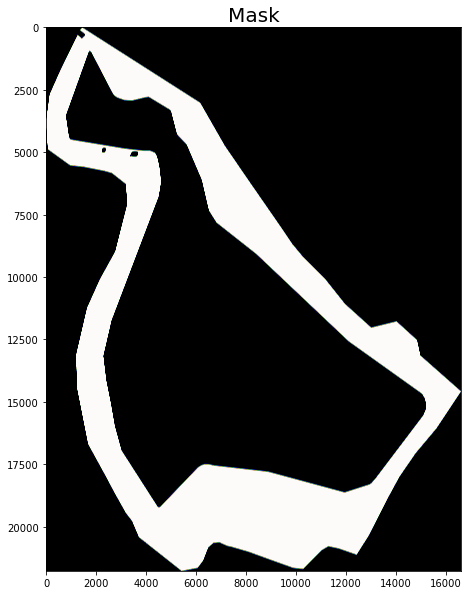

In [260]:
Mask=np.array(dronedata1[:,:,5])
Mask[Mask==65535]=1

f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(111)
pos=ax1.imshow(Mask)
ax1.set_title('Mask',fontsize=20)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);


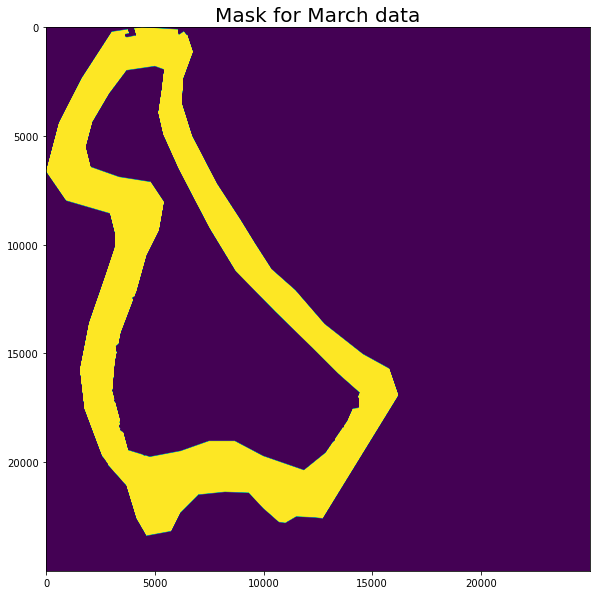

In [26]:
Mask2=np.array(dronedata2>0)
Mask2=Mask2[:,:,0]
Mask2=Mask2.astype('uint8')

f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(111)
pos=ax1.imshow(Mask2)
ax1.set_title('Mask for March data',fontsize=20)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);


In [211]:
n_samples = (Mask==1).sum()
labels = np.unique(Mask)

print('We have {n} samples'.format(n=n_samples))
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

X = dronedata1[Mask==1,:5] 
indices = np.where(Mask == 1)

from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=4).fit(X)
y_pred = gmm.predict(X)
indices = np.where(Mask == 1)
y_pred=y_pred+1
Mask[indices[0],indices[1]]=y_pred


We have 81866931 samples
The training data include 2 classes: [0 1]


In [30]:
n_samples = (Mask2==1).sum()
labels = np.unique(Mask2)

print('We have {n} samples'.format(n=n_samples))
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

X = dronedata2[Mask2==1,:] 
indices = np.where(Mask2 == 1)

from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=4).fit(X)
y_pred = gmm.predict(X)
indices = np.where(Mask2 == 1)
y_pred=y_pred+1
Mask2[indices[0],indices[1]]=y_pred


We have 96224398 samples
The training data include 2 classes: [0 1]


In [18]:
Mask2[indices[0],indices[1]]=y_pred

In [19]:
# next setup a colormap for our map
colors = dict((
    (0, (255, 255, 255, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (244, 164, 96, 255)),    # Purple - Emergent Wetland
    (3, (206, 224, 196, 255)),   # Tan - Sand
    (4, (96, 19, 134, 255)),  # Lime - Herbaceous
   ))


n=4
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

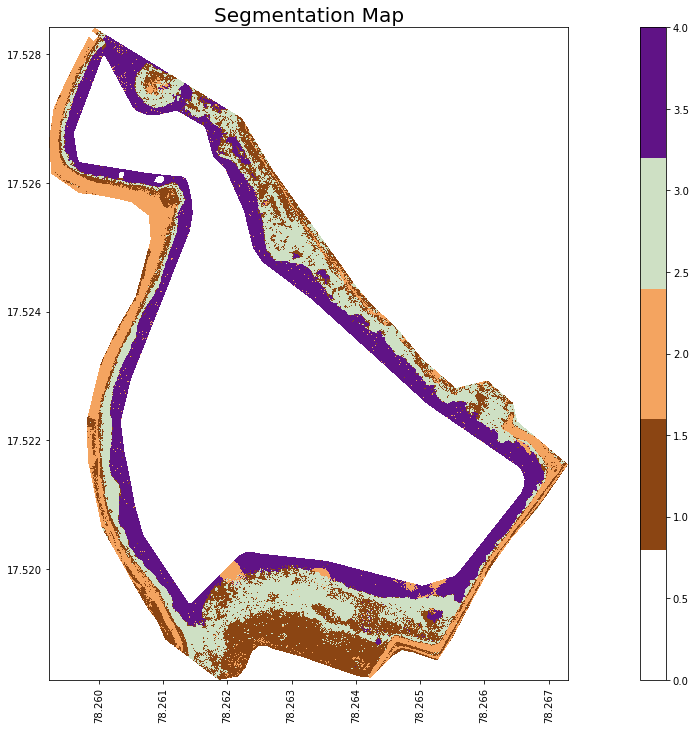

In [299]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
f = plt.figure(figsize=(12,12))
ax1 = f.add_subplot(111)
pos=ax1.imshow(Mask,cmap=cmap, interpolation='none',extent=clipExt); 
ax1.set_title('Segmentation Map',fontsize=20)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=1)

plt.colorbar(pos, cax=cax)


In [36]:
# next setup a colormap for our map
colors = dict((
    (0, (255, 255, 255, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (3, (244, 164, 96, 255)),    # Purple - Emergent Wetland
    (2, (206, 224, 196, 255)),   # Tan - Sand
    (4, (96, 19, 134, 255)),  # Lime - Herbaceous
   ))


n=4
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

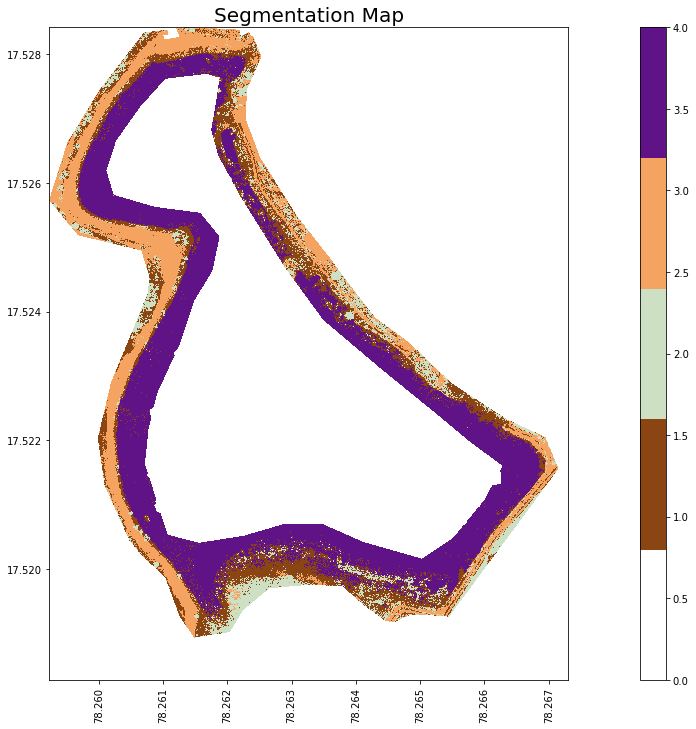

In [38]:

clipExtent = {}
clipExtent['xMin'] = 78.2592307422399216
clipExtent['xMax'] = 78.2672988704719188
clipExtent['yMin'] = 17.5182733390502108
clipExtent['yMax'] = 17.5284223207622105

clipExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])
from mpl_toolkits.axes_grid1 import make_axes_locatable
f = plt.figure(figsize=(12,12))
ax1 = f.add_subplot(111)
pos=ax1.imshow(Mask2[:,:16500],cmap=cmap, interpolation='none',extent=clipExt); 
ax1.set_title('Segmentation Map',fontsize=20)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=1)

plt.colorbar(pos, cax=cax)

In [219]:
y_pred.max()


3